In [1]:
import pandas as pd
import numpy as np
import json
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
import pandas as pd
import rdchiral
import itertools
import pickle
import sys
from tqdm import tqdm 
from rdchiral.main import rdchiralRun, rdchiralRunText, rdchiralReaction, rdchiralReactants
import cobra
from itertools import chain, combinations
import sys
import multiprocessing
from functools import partial
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
sys.path.append('../retrosynthesis/')

from common import *

### input and output

In [2]:
# step1
#input
mnxreac_smile_atom_mapping_rules_file_path = '../../Results/rules/MNXreaction_smiles_atommap_rules_filter.csv'
yeast870_path = '../../Data/model/yeast-GEM-final.csv'
new_met_info_to_GEM_path = '../../Results/not_lipid/top50_0.3_re/metabolites_info_to_GEM_del_top50_0.3.csv'
target_100met_path = '../../Data/100met_with_smiles.xlsx'

In [3]:
def process_rule(rule_smiles, mets_total_smiles):
    score = []
    smiles = []
    if 'C' in rule_smiles or 'c' in rule_smiles:
        for j in mets_total_smiles:
            current_score = calculate_similarity(rule_smiles, j)
            if current_score > 0.3:
                score.append(current_score)
                smiles.append(j)
    else:
        smiles.append(rule_smiles)
        score.append(1)

    if len(score) == 0:
        return rule_smiles, [], []
    elif len(score) > 20:
        top40_data = sorted(zip(score, smiles), reverse=True)[:20]
    else:
        top40_data = sorted(zip(score, smiles), reverse=True)
    
    top40_scores, top40_smiles = zip(*top40_data)
    
    return rule_smiles, list(top40_smiles), list(top40_scores)

In [4]:
def process_retrorule(index_row, mets_total_smiles,retrosys_smiles_calculate_similarity_pd,heterologous_met_smiles):
    rxndb_list_tmp = []
    # newdbSmiles_tmp = []
    failedrxn_tmp = []
    index, row = index_row
    rxn_id, ECnumber, reactants, products = row['MNX_ID'], row['classifs'], row['substrate_smiles'], row['product_smiles']
    deprecated_equ_smiles, reactantSMARTs, productSMARTs, rule = row['deprecated_equ_smiles'], row['ReactantsSMARTs'], row['ProductSMARTs'], row['RetroRules']
    deprecated_equ_smiles = deprecated_equ_smiles.split('>>')
    if rxn_id not in ['MNXR101882', 'MNXR101884', 'MNXR101879', 'MNXR101885', 'MNXR101886', 'MNXR101887',
                        'MNXR103528', 'MNXR103575']:  # ATP NADH conversion stuff
        productSMARTs = productSMARTs.split('.')
        products = products.split('.')
        new_products_smiles = []
        scores = []

        if len(productSMARTs) == len(products):
            for x in range(len(productSMARTs)):  # prepare mets with substructure and sort the reactants combination
                new_products_smile_one,score_one = get_calculate_similarity(products[x],retrosys_smiles_calculate_similarity_pd)
                new_products_smiles.append(new_products_smile_one)
                scores.append(score_one)

            product_prepared = []
            scores_prepared = []
            for lst, score_lst in zip(new_products_smiles, scores):
                if heterologous_met_smiles in lst:
                    if len(new_products_smiles) == 1:  # if only one sub list
                        product_prepared.append([heterologous_met_smiles])
                        scores_prepared.append(score_lst)
                    else:
                        other_lists = [sub_lst for sub_lst in new_products_smiles if sub_lst != lst]
                        tmp_product = list(itertools.product([heterologous_met_smiles], *other_lists))
                        product_prepared += tmp_product

                        tmp_scores = list(itertools.product([score_lst[new_products_smiles.index(lst)]], *scores))
                        scores_prepared += tmp_scores

            for m in range(0, len(product_prepared)):  # apply the rule and output the rxn
                smile = product_prepared[m]
                score = scores_prepared[m]
                
                if len(smile) > 1:
                    product_smile = '.'.join(smile)
                else:
                    product_smile = smile[0]

                retrorule_tmp = rule.split('>>')
                retrorule_tmp = '(' + retrorule_tmp[0] + ')>>' + '(' + retrorule_tmp[1] + ')'            
                product_smile_tmp = product_smile
                try:
                    # print('product_smile_tmp',product_smile_tmp)
                    product_mol = Chem.MolFromSmiles(product_smile_tmp)
                    reaction = AllChem.ReactionFromSmarts(retrorule_tmp)
                    reactant_smiles = reaction.RunReactants((product_mol,))
                    smiles = [Chem.MolToSmiles(x[0]) for x in reactant_smiles]
                    reactant_smiles = list(set(smiles))

                    for reactant_smile in reactant_smiles:
                        if len(deprecated_equ_smiles) > 0:
                            if deprecated_equ_smiles[0] == '':
                                reactant_smile_final = reactant_smile
                            else:
                                reactant_smile_final = reactant_smile + '.' + deprecated_equ_smiles[0]
                            if deprecated_equ_smiles[1] == '':
                                product_smile_final = product_smile_tmp
                            else:
                                product_smile_final = product_smile_tmp + '.' + deprecated_equ_smiles[1]
                        rxn_smiles = reactant_smile + '>>' + product_smile_tmp
                        rxn_smiles_final = reactant_smile_final + '>>' + product_smile_final
                        
                        tmp = {
                            'EC number': ECnumber,
                            'rule': rule,
                            'templateID': rxn_id,
                            'templateSubstrate': products,
                            'rxn_smiles_basic': rxn_smiles,
                            'rxn_smiles_final': rxn_smiles_final,
                            'reactant_smile': reactant_smile,
                            'productsmile': product_smile_tmp,
                            'similarity': score
                        }
                        if check_rule(tmp['rxn_smiles_basic'])=='blance':
                            rxndb_list_tmp.append(tmp)  
                            # mets_tmp = reactant_smile.split('.')      
                            # for reactant in mets_tmp:             
                            #     if reactant not in mets_total_smiles and reactant not in newdbSmiles_tmp:         
                            #         newdbSmiles_tmp.append(reactant)        
                except:
                    failedrxn_tmp.append(rxn_id)
                
    return(rxndb_list_tmp,failedrxn_tmp)

In [5]:
rules_product_smiles_lst = []
retrorules = pd.read_csv(mnxreac_smile_atom_mapping_rules_file_path)
for index,row in retrorules.iterrows():
    tmp  = row['product_smiles'].split('.')
    for i in tmp:
        if i not in rules_product_smiles_lst:
            rules_product_smiles_lst.append(i)
print('rules_product_smiles_lst',len(rules_product_smiles_lst))

rules_product_smiles_lst 9708


In [6]:
target_100met = pd.read_excel(target_100met_path)
target_100met = target_100met[target_100met['Group']=='heterologous']
target_100met = target_100met[~target_100met['Smiles'].isna()]
target_100met.reset_index(drop=True,inplace=True)
target_100met['byproduct'] = ' '
target_100met['EC number'] = ' '
target_100met.head()

,Name,Formula,KEGG ID,CHEBI ID,Group,class,Gene target,Smiles,byproduct,EC number
0,L-Phenylacetylcarbinol,C9H10O2,NaN,NaN,heterologous,alcohol,Link,CC(=O)[C@H](C1=CC=CC=C1)O,,
1,1-Butanol,C4H10O,C06142,28885.0,heterologous,alcohol,Link,CCCCO,,
2,(S)-Reticuline,C19H23NO4,C02105,16718.0,heterologous,alkaloid,Link,CN1CCC2=CC(=C(C=C2[C@@H]1CC3=CC(=C(C=C3)OC)O)O)OC,,
3,Psilocybin,C12H17N2O4P,C07576,8614.0,heterologous,alkaloid,Link,CN(C)CCC1=CNC2=C1C(=CC=C2)OP(=O)(O)O,,
4,Nicotianamine,C12H21N3O6,C05324,17721.0,heterologous,amino acid,Link,C1CN([C@@H]1C(=O)O)CC[C@@H](C(=O)O)NCC[C@@H](C...,,


In [7]:
len(target_100met)

44

## byproduct prediction

In [8]:
def check_productsmile(smiles):#only keep smiles with carbon
    smiles_lst = smiles.split('.')
    smiles_lst = [x for x in smiles_lst if smiles_has_carbon(x)]
    return len(smiles_lst)

In [9]:
# target_100met = target_100met[target_100met['Name']=='Nicotianamine']

In [10]:
target_100met

,Name,Formula,KEGG ID,CHEBI ID,Group,class,Gene target,Smiles,byproduct,EC number
0,L-Phenylacetylcarbinol,C9H10O2,NaN,NaN,heterologous,alcohol,Link,CC(=O)[C@H](C1=CC=CC=C1)O,,
1,1-Butanol,C4H10O,C06142,28885.0,heterologous,alcohol,Link,CCCCO,,
2,(S)-Reticuline,C19H23NO4,C02105,16718.0,heterologous,alkaloid,Link,CN1CCC2=CC(=C(C=C2[C@@H]1CC3=CC(=C(C=C3)OC)O)O)OC,,
3,Psilocybin,C12H17N2O4P,C07576,8614.0,heterologous,alkaloid,Link,CN(C)CCC1=CNC2=C1C(=CC=C2)OP(=O)(O)O,,
4,Nicotianamine,C12H21N3O6,C05324,17721.0,heterologous,amino acid,Link,C1CN([C@@H]1C(=O)O)CC[C@@H](C(=O)O)NCC[C@@H](C...,,
5,4-Hydroxymandelic,C8H8O4,C11527,16388.0,heterologous,aromatic,Link,C1=CC(=CC=C1C(C(=O)O)O)O,,
6,Cinnamate,C9H8O2,C00423,15669.0,heterologous,aromatic,Link,C1=CC=C(C=C1)/C=C/C(=O)[O-],,
7,Mandelic,C8H8O3,C01984,17756.0,heterologous,aromatic,Link,C1=CC=C(C=C1)[C@@H](C(=O)O)O,,
8,p-Coumaric acid,C9H8O3,C00811,32374.0,heterologous,aromatic,Link,C1=CC(=CC=C1/C=C/C(=O)O)O,,
9,Rosmarinate,C18H16O8,C01850,50371.0,heterologous,aromatic,Link,C1=CC(=C(C=C1C[C@H](C(=O)O)OC(=O)/C=C/C2=CC(=C...,,


In [11]:
def draw_reaction(smiles,figure_path):
    reactant_smiles = smiles.split('>>')[0]
    product_smiles = smiles.split('>>')[1]
    reactant_mol = Chem.MolFromSmiles(reactant_smiles)
    product_mol = Chem.MolFromSmiles(product_smiles)
    img1 = Draw.MolToImage(reactant_mol)
    img2 = Draw.MolToImage(product_mol)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 10))
    ax1.imshow(img1)
    ax1.set_title('Reactant')
    ax1.axis('off')
    ax2.imshow(img2)
    ax2.set_title('Product')
    ax2.axis('off')
    # 调整子图之间的间距
    plt.tight_layout()
    # 保存图像
    plt.savefig(figure_path, dpi=200, bbox_inches='tight')

In [17]:
for index,row in tqdm(target_100met.iterrows(),total=len(target_100met)):
    # if index > 29 :
        # if row['byproduct']==' ':
        print(row['Name'])
        heterologous_met_smiles = row['Smiles']
        heterologous_met_smiles = normalize_smiles(heterologous_met_smiles)

        model_met = get_GEM_all_smiles(yeast870_path)
        new_met_info_to_GEM = pd.read_csv(new_met_info_to_GEM_path,index_col=None)
        new_met_info_to_GEM.head(6)
        new_met = new_met_info_to_GEM[new_met_info_to_GEM['ID'].apply(lambda x:'sn_' in x)]['new_met_smiles'].to_list()
        new_met = [normalize_smiles(x) for x in new_met if 'C' in x or 'c' in x]
        # new_met = []
        # add heterologous_met_smiles to model_met list
        new_model_and_heterologous_met = model_met + new_met
        new_model_and_heterologous_met.append(heterologous_met_smiles)
        new_model_and_heterologous_met = [smile for smile in new_model_and_heterologous_met if '.' not in smile]
        new_model_and_heterologous_met = [smile for smile in new_model_and_heterologous_met if 'C' in smile or 'c' in smile] ###只筛第一轮
        print(len(new_model_and_heterologous_met))
        #calculate similarity
        num_processes = 60
        pool = multiprocessing.Pool(num_processes)
        retrosys_smiles_calculate_similarity = {'rules_smiles': [],
                                                'smiles_in_mets_total_smiles': [],
                                                'scores': []}


        process_rule_partial = partial(process_rule, mets_total_smiles=new_model_and_heterologous_met)
        for result in tqdm(pool.imap(process_rule_partial, rules_product_smiles_lst, chunksize=50), total=len(rules_product_smiles_lst)):
            if result[0] not in retrosys_smiles_calculate_similarity['rules_smiles']:
                retrosys_smiles_calculate_similarity['rules_smiles'].append(result[0]) 
                retrosys_smiles_calculate_similarity['smiles_in_mets_total_smiles'].append(result[1]) 
                retrosys_smiles_calculate_similarity['scores'].append(result[2]) 
        pool.close()
        pool.join()

        retrosys_smiles_calculate_similarity_pd = pd.DataFrame(retrosys_smiles_calculate_similarity)

        rxndb_list = []
        # newdbSmiles = []
        failedrxn = []
        num_processes =60  #  adjust the number of processes according to your needs
        pool = multiprocessing.Pool(num_processes)
        # Execute in parallel using process pool

        # Create a partial function that passes mets_total_smiles and mets_total_mol as default parameters to the process_retrorule function
        process_retrorule_partial = partial(process_retrorule, mets_total_smiles=new_model_and_heterologous_met,retrosys_smiles_calculate_similarity_pd = retrosys_smiles_calculate_similarity_pd,heterologous_met_smiles = heterologous_met_smiles)

        # Using the process pool to execute in parallel, the chunksize parameter is placed inside the imap function.
        for result in tqdm(pool.imap(process_retrorule_partial, retrorules.iterrows(), chunksize=50), total=len(retrorules)):
            # if result == ([], [], []):
            #     pass
            # else:
            #     print(result)
            if result[0] :  #  check if the result is not empty
                rxndb_list.extend(result[0]) 
            # if result[1] is not None:
            #     newdbSmiles.extend(result[1])
            if result[1]:
                failedrxn.extend(result[1])  

        pool.close()
        pool.join()

        rxndb = {}
        for i, rxn_dict in enumerate(rxndb_list):
            # generate a unique key for each reaction, for example "rxn0"，"rxn1"，"rxn2"，...
            key = f'rxn{i+1}'
            # merge to the dictionary
            rxndb[key] = rxn_dict
        # with open(rxndb_path, 'w') as json_file:
        #     json.dump(rxndb, json_file)

        # with open(rxndb_path, 'r') as f:
        #     rxndb = json.load(f)
        print('rxndb num',len(rxndb))
        # print('newdbSmiles num',len(newdbSmiles))
        print('failedrxn num',len(failedrxn))

        miss_smiles = ['C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OCC3C(C(C(O3)N4C=NC5=C(N=CN=C54)N)O)O)O)O',#NADH
                        'C1C=CN(C=C1C(=O)N)C2C(C(C(O2)COP(=O)(O)OP(=O)(O)OCC3C(C(C(O3)N4C=NC5=C(N=CN=C54)N)OP(=O)(O)O)O)O)O']#NADPH
        miss_reaction_lst = []
        for k,v in rxndb.items():
            reactant_smile_lst = v['rxn_smiles_final'].split('>>')[0].split('.')
            if any(compare_smiles_inchikey(miss_smiles[0],met) for met in reactant_smile_lst):
                # print(k,v['rxn_smiles_final'])
                miss_reaction_lst.append(k)
            if any(compare_smiles_inchikey(miss_smiles[1],met) for met in reactant_smile_lst):
                # print(k,v['rxn_smiles_final'])    
                miss_reaction_lst.append(k)
        print(len(miss_reaction_lst))

        result_df = {'ID':[],
                    'reactant_smile':[],
                    'productsmile':[],
                    'rxn_smiles_basic':[],
                    'templateID':[],
                    'EC number':[],}

        for k,v in rxndb.items():
            result_df['ID'].append(k)
            result_df['reactant_smile'].append(v['reactant_smile'])
            result_df['productsmile'].append(v['productsmile'])
            result_df['rxn_smiles_basic'].append(v['rxn_smiles_basic'])
            result_df['templateID'].append(v['templateID'])
            result_df['EC number'].append(v['EC number'])

        result_df = pd.DataFrame({'ID': result_df['ID'],
                                'reactant_smile': result_df['reactant_smile'],
                                'productsmile': result_df['productsmile'],
                                'rxn_smiles_basic': result_df['rxn_smiles_basic'],
                                'templateID': result_df['templateID'],
                                'EC number': result_df['EC number'],
                                })

        result_df.drop_duplicates(subset=['reactant_smile', 'productsmile'], inplace=True)
        result_df.reset_index(drop=True, inplace=True)

        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.OO']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.O=C=O']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.O=S([O-])[O-]']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.[SH-]']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.O=P([O-])([O-])OP(=O)([O-])O']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.II']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.[NH4+]']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.[Br-]']
        result_df = result_df[result_df['productsmile']!=heterologous_met_smiles+'.O=S(=O)([O-])[O-]']

        unique_smiles = []
        for i in result_df['reactant_smile']:
            if all(compare_smiles_inchikey(x,i)!=1 for x in unique_smiles):
                unique_smiles.append(i)
            else:
                pass
        result_df = result_df[result_df['reactant_smile'].isin(unique_smiles)]

        unique_productsmile = []
        for i in result_df['productsmile']:
            if i.replace('O=P(O)(O)','') not in unique_productsmile:
                unique_productsmile.append(i)
            else:
                pass
        result_df = result_df[result_df['productsmile'].isin(unique_productsmile)]

        result_df['productsmile_num'] = result_df['productsmile'].apply(lambda x: check_productsmile(x))
        result_df = result_df[result_df['productsmile_num']==1]
        result_df = result_df[~result_df['ID'].isin(miss_reaction_lst)]

        res = result_df['reactant_smile'].to_list()
        ec_lst = []
        for k,v in rxndb.items():
            if v['reactant_smile'] in res:
                ec_lst.append(v['EC number'])

        print(row['Name'],len(result_df))
        print(row['Name'],ec_lst)

        # target_100met.loc[index,'byproduct'] = str(res)
        target_100met.loc[index,'byproduct'] = len(result_df)
        target_100met.loc[index,'EC number'] = str(ec_lst)
        # target_100met.to_csv(heterologous_met_byproduct_result_path,index=None)
        ###################################################################################  get Stable7
        clean_deepec_gene2ec_dict_path = '../../Results/ECnumber_prediction/clean_deepec_gene2ec_dict.json'
        with open(clean_deepec_gene2ec_dict_path, 'r') as f:
            clean_deepec_gene2ec_dict = json.load(f)
        clean_deepec_ec2gene_dict = get_ec2gene_dict_clean(clean_deepec_gene2ec_dict)

        result_df_exp = {'Product name':[],
                    'Predicted reaction ID':[],
                    'templateID':[],
                    'Predicted reaction':[],
                    'Predicted EC number of reaction':[]}
        num = 0

        for index2,row2 in result_df.iterrows():
            num+=1
            reaction_smiles = row2['rxn_smiles_basic'].split('>>')[1]+'>>'+row2['rxn_smiles_basic'].split('>>')[0]
        #     try:
        #         img_path = f"../Data/Predicted reaction_heter/{row['Name']}_{num}.png"
        #         draw_reaction(reaction_smiles,img_path)
        #     except:
        #         print(row['Name'],num,'draw_reaction faile!')
            result_df_exp['Product name'].append(row['Name'])
            result_df_exp['Predicted reaction ID'].append(num)
            result_df_exp['templateID'].append(row2['templateID'])
            result_df_exp['Predicted reaction'].append(reaction_smiles)
            result_df_exp['Predicted EC number of reaction'].append(row2['EC number'])

        result_df_exp = pd.DataFrame(result_df_exp)
        result_df_exp['Predicted genes of reaction'] = result_df_exp['Predicted EC number of reaction'].apply(lambda x:x.split(';'))
        result_df_exp['Predicted genes of reaction'] = result_df_exp['Predicted genes of reaction'].apply(lambda x:['.'.join(ec.split('.')[0:3]) for ec in x])
        result_df_exp['Predicted genes of reaction'] = result_df_exp['Predicted genes of reaction'].apply(lambda x:[gene for ec in x if ec in clean_deepec_ec2gene_dict for gene in clean_deepec_ec2gene_dict[ec]] if len(x)>0 else [])
        # 处理“IgnoreMet”列
        ignore_met_list = []
        for template_id in result_df_exp['templateID']:
            deprecated_equ = retrorules[retrorules['MNX_ID'] == template_id]['deprecated_equ'].to_list()
            if deprecated_equ:
                deprecated_equ = deprecated_equ[0]
                if '>>' in deprecated_equ:
                    parts = deprecated_equ.split('>>')
                    ignore_met = parts[1] + '>>' + parts[0]
                elif ' <=> ' in deprecated_equ:
                    parts = deprecated_equ.split(' <=> ')
                    ignore_met = parts[1] + '>>' + parts[0]
                else:
                    ignore_met = ''
            else:
                ignore_met = ''
            ignore_met_list.append(ignore_met)
        result_df_exp['IgnoreMet'] = ignore_met_list

        result_df_exp[['Product name','Predicted reaction ID','Predicted reaction','IgnoreMet','Predicted genes of reaction']].to_csv(f"../../Results/byproduct/hetergrologous/{row['Name']}.csv",index=None)

  0%|          | 0/44 [00:00<?, ?it/s]

L-Phenylacetylcarbinol
1884


100%|██████████| 21921/21921 [00:22<00:00, 995.54it/s] 


rxndb num 90
failedrxn num 0
5


  2%|▏         | 1/44 [27:52<19:58:55, 1672.92s/it]

L-Phenylacetylcarbinol 4
L-Phenylacetylcarbinol ['1.14.13.-', '1.14.13.-', '1.14.13.-', '1.1.1;1.1.1.-;1.1.1.4', '1.14.13.189', '1.14.13.189', '1.14.13.189', '1.1.1.2', '1.14.13.-;1.14.13.243', '1.14.13.-;1.14.13.243', '1.14.13.-;1.14.13.243', '1.14.13.7', '1.14.13.7', '1.14.13.7', '1.14.13.-;1.14.13.236', '1.14.13.-;1.14.13.236', '1.14.13.-;1.14.13.236']
1-Butanol
1884


100%|██████████| 21921/21921 [00:20<00:00, 1076.77it/s]


rxndb num 431
failedrxn num 0
65


  5%|▍         | 2/44 [41:35<13:40:45, 1172.51s/it]

1-Butanol 1
1-Butanol ['1.1.3.20', '1.1.3.20']
(S)-Reticuline
1884


100%|██████████| 21921/21921 [00:21<00:00, 1010.70it/s]


rxndb num 720
failedrxn num 0
18


  7%|▋         | 3/44 [55:38<11:38:38, 1022.40s/it]

(S)-Reticuline 15
(S)-Reticuline ['1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.19.68;1.14.21.5', '1.14.19.68;1.14.21.5', '1.14.21.1', '1.14.21.1', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.13.56', '1.14.13.56', '1.14.13.56', '1.14.13.56', '1.14.13.56', '1.14.13.57', '1.14.13.57', '1.14.13.57', '1.14.13.57', '1.14.13.57', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102', '1.14.13.91', '1.14.13.91', '1.14.13.91', '1.14.13.91', '1.14.13.91', '1.14.13.-', '1.14.13.-', '1.14.13.91', '1.14.13.91', '1.14.13.91', '1.14.13.91', '1.14.13.91']
Psilocybin
18

100%|██████████| 21921/21921 [00:20<00:00, 1072.37it/s]


rxndb num 52
failedrxn num 0
0


  9%|▉         | 4/44 [1:08:52<10:21:20, 932.02s/it]

Psilocybin 6
Psilocybin ['3.1.8.1', '1.14.13.8', '1.13.11.52', '1.14.13.56', '1.14.13.56', '1.14.13.56', '1.14.13.57', '1.14.13.57', '1.14.13.57', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102']
Nicotianamine
1884


100%|██████████| 21921/21921 [00:20<00:00, 1054.63it/s]


rxndb num 44
failedrxn num 0
0


 11%|█▏        | 5/44 [1:22:27<9:38:21, 889.78s/it] 

Nicotianamine 0
Nicotianamine []
4-Hydroxymandelic
1884


100%|██████████| 21921/21921 [00:20<00:00, 1051.32it/s]


rxndb num 514
failedrxn num 0
37


 14%|█▎        | 6/44 [1:36:15<9:10:17, 868.89s/it]

4-Hydroxymandelic 11
4-Hydroxymandelic ['1.14.13.19', '1.14.13.19', '1.14.13.-;1.6.5.2', '1.14.13.-;1.6.5.2', '3.1.3.25', '3.1.3.25', '3.1.3.25', '3.1.3.25', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13', '1.14.13', '1.14.18.1', '1.14.18.1', '1.14.18.1', '4.2.1.94', '1.14.13.21', '1.14.13.21', '1.14.13.-', '1.14.13.-', '1.14.13.21', '1.14.13.21', '1.1.1.107;1.1.1.122', '3.1.3.25', '3.1.3.25', '1.14.13.88', '1.14.13.88', '1.14.13.88', '1.14.13.88', '1.14.19.55', '1.14.19.55', '3.1.3.25', '3.1.3.25']
Cinnamate
1884


100%|██████████| 21921/21921 [00:21<00:00, 1035.81it/s]


rxndb num 194
failedrxn num 0
0


 16%|█▌        | 7/44 [1:50:07<8:48:22, 856.82s/it]

Cinnamate 9
Cinnamate ['3.6.1.7', '1.3.1.31', '1.1.1.184;1.2.1.5', '1.14.13.189', '1.14.13.189', '1.14.13.189', '4.1.1.-;4.1.1.102', '1.14.14.91', '1.14.14.91', '1.14.14.91', '1.2.1.3', '1.1.1.184', '1.14.12.19', '1.14.13.12', '1.14.13.12', '1.14.13.12', '1.14.13.11;1.14.14.91', '1.14.13.11;1.14.14.91', '1.14.13.11;1.14.14.91', '1.14.13.14;1.14.14.91', '1.14.12.19', '1.14.14.8', '1.14.14.8', '1.14.14.8']
Mandelic
1884


100%|██████████| 21921/21921 [00:20<00:00, 1051.05it/s]


rxndb num 25
failedrxn num 0
2


 18%|█▊        | 8/44 [2:03:50<8:27:40, 846.13s/it]

Mandelic 1
Mandelic ['1.2.1.3']
p-Coumaric acid
1884


100%|██████████| 21921/21921 [00:20<00:00, 1072.38it/s]


rxndb num 467
failedrxn num 0
13


 20%|██        | 9/44 [2:17:41<8:10:49, 841.42s/it]

p-Coumaric acid 11
p-Coumaric acid ['1.14.13.7', '1.14.13.7', '1.14.13.63', '1.14.13.63', '1.14.13.63', '1.14.13.63', '1.14.13.6', '1.14.13.6', '1.14.13.219;1.14.13.7', '1.14.13.219;1.14.13.7', '1.14.13.-;1.6.5.2', '1.14.13.-;1.6.5.2', '1.14.13.244;1.14.13.M20', '1.14.13.244;1.14.13.M20', '1.14.13.-;1.14.13.220', '1.14.13.-;1.14.13.220', '1.14.13.44', '1.14.13.44', '1.14.14', '1.14.14', '1.14.13', '1.14.13', '1.14.13.M33', '1.14.13.M33', '1.14.18.1', '1.14.18.1', '1.14.18.1', '1.14.18.1', '1.14.18.1', '1.14.18.1', '3.1.3.2;3.1.3.48;3.1.3.76', '1.14.14.57', '1.14.13.18', '1.14.13.18', '4.2.1.94', '1.14.13.21', '1.14.13.21', '1.14.13.88', '1.14.13.88', '1.14.14.9', '1.14.14.9', '1.14.13.3;1.14.14.9', '1.14.13.3;1.14.14.9', '1.14.13.127', '1.14.13.127', '1.14.13.127', '1.14.19.55', '1.14.19.55', '5.2.-.-;5.2.1.-', '1.14.13.236', '1.14.13.236', '1.14.14.20', '1.14.14.20', '1.14.14.27', '1.14.14.27', '1.3.1.74', '1.14.13.3;1.14.14.9', '1.14.13.3;1.14.14.9', '1.14.13.127', '1.14.13.127']
Ros

100%|██████████| 21921/21921 [00:21<00:00, 1028.10it/s]


rxndb num 1220
failedrxn num 0
143


 23%|██▎       | 10/44 [2:32:27<8:04:34, 855.14s/it]

Rosmarinate 16
Rosmarinate ['1.14.14.1', '3.1.1.70', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.3.1.29', '1.3.1.29', '1.3.1.49', '1.3.1.49', '1.3.1.29', '1.3.1.29', '1.13.11.-', '1.13.11.-', '1.3.1.29', '1.3.1.29', '1.14.14.-;1.14.14.1', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '3.1.1', '1.1.1.-', '1.1.1.-', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14', '1.14', '1.14', '1.14', '1.14', '1.14', '1.14.13.36', '1.14.13.36', '1.14.13.36', '1.14.13.36', '1.14.13.36', '1.14.13.36', '1.14;1.14.13.36', '1.14;1.14.13.36', '1.14;1.14.13.3

100%|██████████| 21921/21921 [00:21<00:00, 1039.94it/s]


rxndb num 3684
failedrxn num 0
17


 25%|██▌       | 11/44 [2:53:06<8:54:53, 972.52s/it]

Salidroside 16
Salidroside ['3.1.3.69', '3.1.3.69', '3.1.3.69', '3.1.3.69', '3.2.1.-', '1.14.13.19', '1.14.13.19', '3.2.1.63', '2.4.1.247', '2.4.1.247', '3.2.1.-;3.2.1.21', '3.2.1.-;3.2.1.21', '2.4.1.-;2.4.1.282', '2.4.1.-;2.4.1.282', '2.4.1.321', '2.4.1.332', '2.4.1.332', '3.2.1', '3.2.1', '3.2.1.149', '3.2.1.149', '3.2.1.149', '3.2.1.149', '2.4.1.230', '2.4.1.230', '3.2.1.40', '3.2.1.40', '3.2.1.40', '1.14.13', '1.14.13', '3.2.1', '3.2.1.3', '3.2.1.70', '3.2.1.70', '3.2.1.21;3.2.1.25;3.2.1.58;3.2.1.74', '3.2.1.21', '1.1.99.13', '1.1.99.13', '1.1.99.13', '3.2.1.22', '5.4.99.16', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '3.2.1.23', '3.2.1.23', '1.14.13.103', '1.14.13.103', '1.14.13.88', '1.14.13.88', '1.14.13.88', '1.14.13.88', '2.4.1.359;2.4.1.dr', '2.4.1.359;2.4.1.dr', '3.2.1.23', '3.2.1.23', '3.2.1.22', '3.2.1.22', '3.2.1.22', '3.2.1.22', '3.2.1.117', '3.2.1.117', '3.2.1.74', '3.2.1.74', '3.2.1.74', '3.2.1.74', '2.4.1.247', '2.4.1.247', '2.4.1.247', '2.4.1.247', '1.14.13.89

100%|██████████| 21921/21921 [00:20<00:00, 1067.90it/s]


rxndb num 199
failedrxn num 0
14


 27%|██▋       | 12/44 [3:06:47<8:14:11, 926.60s/it]

Tyrosol 2
Tyrosol ['1.14.13.-;1.14.18.1', '1.14.13.-;1.14.18.1', '1.14.14.1', '1.14.14.1', '1.14.14', '1.14.14']
Arachidonate
1884


100%|██████████| 21921/21921 [00:22<00:00, 968.78it/s] 


rxndb num 75
failedrxn num 0
1


 30%|██▉       | 13/44 [3:20:19<7:40:40, 891.64s/it]

Arachidonate 19
Arachidonate ['1.2.1.-', '1.2.1.-', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.2.1;1.2.1.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '5.2.1.M1']
Docosahexaenoate
1884


100%|██████████| 21921/21921 [00:33<00:00, 650.83it/s]


rxndb num 147
failedrxn num 0
1


 32%|███▏      | 14/44 [3:34:44<7:21:46, 883.55s/it]

Docosahexaenoate 23
Docosahexaenoate ['5.3.3.13', '5.3.3.13', '5.3.3.13', '5.3.3.13', '5.3.3.13', '5.3.3.13', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.-;1.13.11.12;1.13.11.58', '1.13.11.12', '1.13.11.12', '1.13.11.12', '1.13.11.12', '1.13.11.12', '1.13.11.12', '1.13.11.12', '1.13.11.12', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.13.11.77', '1.13.11.77', '1.2.1;1.2.1.-', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.31', '1.13.11.31', '1.13.

100%|██████████| 21921/21921 [00:21<00:00, 1043.54it/s]


rxndb num 66
failedrxn num 0
1


 34%|███▍      | 15/44 [3:49:33<7:07:53, 885.28s/it]

Eicosapentaenoic acid 13
Eicosapentaenoic acid ['1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1', '1.2.1;1.2.1.-', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '1.13.11.34', '5.2.1.M1']
Docosanol
1884


100%|██████████| 21921/21921 [00:20<00:00, 1080.03it/s]


rxndb num 201
failedrxn num 0
58


 36%|███▋      | 16/44 [4:02:53<6:41:12, 859.73s/it]

Docosanol 1
Docosanol ['1.1.3.20', '1.1.3.20']
Catechin
1884


100%|██████████| 21921/21921 [00:21<00:00, 1005.18it/s]


rxndb num 2842
failedrxn num 0
143


 39%|███▊      | 17/44 [4:18:31<6:37:24, 883.15s/it]

Catechin 16
Catechin ['1.1.1.252', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.3.1.29', '1.3.1.49', '1.3.1.29', '1.3.1.29', '1.13.11.-', '1.3.1.29', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.13.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.2', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;

100%|██████████| 21921/21921 [00:21<00:00, 1017.50it/s]


rxndb num 2179
failedrxn num 0
97


 41%|████      | 18/44 [4:33:31<6:24:55, 888.29s/it]

Genistein 18
Genistein ['1.1.1.252', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.3.1.45', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.99', '1.13.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.14.14.1', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '1.14.13.21', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '4.2.1.94', '1.14.13.52;1.14.14.88', '1.14.13.

100%|██████████| 21921/21921 [00:21<00:00, 1033.70it/s]


rxndb num 3057
failedrxn num 0
131


 43%|████▎     | 19/44 [4:49:36<6:19:42, 911.31s/it]

Kaempferol 18
Kaempferol ['1.1.1.252', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.99', '1.13.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.14.14.1', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '1.14.13.21', '1.14.13.21;

100%|██████████| 21921/21921 [00:21<00:00, 1037.56it/s]


rxndb num 2169
failedrxn num 0
88


 45%|████▌     | 20/44 [5:04:50<6:04:48, 912.00s/it]

Naringenin 21
Naringenin ['5.5.1.6', '3.7.1.4', '1.1.1.252', '1.1.1.219', '1.1.1.219', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '5.5.1.6', '5.5.1.6', '1.1.1.219', '1.1.1.219', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.13.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.1.1.348', '1.1.1.348', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.11;1.11.2.1', '5.5.1.6', '5.5.1.6', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '1.1.1.184;1.1.1.209;1.1.1.213;1.1.1.50', '1.1.1.184', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '1.1.1.246;1.1.1.348', '1.1.1.219', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '4.2.1.94', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.1

100%|██████████| 21921/21921 [00:21<00:00, 1004.45it/s]


rxndb num 3649
failedrxn num 0
185


 48%|████▊     | 21/44 [5:21:45<6:01:28, 942.98s/it]

Quercetin 18
Quercetin ['1.1.1.252', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.3.1.29', '1.3.1.49', '1.3.1.29', '1.3.1.29', '1.13.11.-', '1.3.1.29', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.99', '1.13.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.14.1', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.2', '1.97.1.2', '1.97.1.2', '1.14.13.21', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.52;1.14.14.

100%|██████████| 21921/21921 [00:21<00:00, 1019.99it/s]


rxndb num 65
failedrxn num 0
7


 50%|█████     | 22/44 [5:35:46<5:34:31, 912.34s/it]

Astaxanthin 8
Astaxanthin ['1.13.11.51', '1.13.11.51', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.13.11.71;1.14.99.-', '1.13.11.71;1.14.99.-', '1.14.13.90', '1.14.-.-', '1.14.13.90', '1.1.1.M48', '1.14.13.129', '1.14.13']
Betaxanthin
1884


100%|██████████| 21921/21921 [00:21<00:00, 1003.30it/s]


rxndb num 354
failedrxn num 0
4


 52%|█████▏    | 23/44 [5:50:05<5:13:47, 896.55s/it]

Betaxanthin 6
Betaxanthin ['1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.19.68;1.14.21.5', '1.14.21.1', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.21.3', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102', '1.14.13.71;1.14.14.102']
β-Carotene
1884


100%|██████████| 21921/21921 [00:22<00:00, 981.20it/s]


rxndb num 113
failedrxn num 0
0


 55%|█████▍    | 24/44 [6:03:50<4:51:41, 875.08s/it]

β-Carotene 18
β-Carotene ['1.14.13.-', '1.14.13.-', '1.14.14.-;1.14.14.1', '1.13.11.67;1.13.12.12', '1.13.11.67;1.13.12.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.48', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13;1.14.14.1', '1.14.13;1.14.14.1', '1.14.13;1.14.14.1', '1.14.13.78', '1.14.13', '1.14.13', '1.14.13.-;1.14.13.119;1.14.14.149', '1.13.11.75', '1.13.11.75', '1.13.11.75', '1.14.13.-;1.14.14.149', '1.14.13.133', '1.14.13.133', '1.14.13.133', '1.14.13;1.14.13.143', '1.14.13.144', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.48', '1.14.13.119', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.106', '1.14.13.80;1.14.14.53', '1.3.8.2', '1.3.8.2', '1.3.8.2', '1.3.8.2']
Artemisinic acid
1884


100%|██████████| 21921/21921 [00:21<00:00, 1021.05it/s]


rxndb num 55
failedrxn num 0


 57%|█████▋    | 25/44 [6:17:33<4:32:09, 859.47s/it]

2
Artemisinic acid 9
Artemisinic acid ['1.14.13.107', '1.14.13.107', '1.14.13.107', '1.3.1.-;1.3.1.92', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13;1.14.13.48', '1.14.13.49', '1.14.13.49', '1.14.13.79', '1.14.13.79', '1.14.13.79', '1.14.13.79', '1.14.13.107', '1.14.13.-;1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.-', '1.14.13.48', '1.14.-.-', '1.14.-.-', '1.1.1.-', '4.2.1.138', '1.14.13.80;1.14.14.53']
3-Hydroxypropanoate
1884


100%|██████████| 21921/21921 [00:21<00:00, 1002.02it/s]


rxndb num 101
failedrxn num 0
29


 59%|█████▉    | 26/44 [6:30:51<4:12:18, 841.01s/it]

3-Hydroxypropanoate 0
3-Hydroxypropanoate []
Adipic acid
1884


 61%|██████▏   | 27/44 [6:44:33<3:56:40, 835.30s/it]

rxndb num 4
failedrxn num 0
1
Adipic acid 1
Adipic acid ['1.2.1;1.2.1.-']
cis,cis-Muconate
1884


 64%|██████▎   | 28/44 [6:58:18<3:41:53, 832.11s/it]

rxndb num 9
failedrxn num 0
0
cis,cis-Muconate 1
cis,cis-Muconate ['5.5.1.1']
Itaconic acid
1884


 66%|██████▌   | 29/44 [7:11:42<3:25:55, 823.68s/it]

rxndb num 9
failedrxn num 0
0
Itaconic acid 3
Itaconic acid ['1.2.1;1.2.1.-', '1.2.1;1.2.1.-', '3.1.1']
Ethylene
1884


 68%|██████▊   | 30/44 [7:25:46<3:13:36, 829.77s/it]

rxndb num 1
failedrxn num 0
0
Ethylene 1
Ethylene ['1.14.13.69']
1,3,5-Trihydroxyxanthone
1884


100%|██████████| 21921/21921 [00:21<00:00, 1021.78it/s]


rxndb num 2226
failedrxn num 0
89


 70%|███████   | 31/44 [7:41:08<3:05:44, 857.29s/it]

1,3,5-Trihydroxyxanthone 16
1,3,5-Trihydroxyxanthone ['1.14.14.1', '1.14.14.1', '1.1.1.252', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.99', '1.13.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.11;1.11.2.1', '1.14.14.1', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.36;3.1.3.48', '3.1.3.2', '3.1.3.2', '3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '1.14.13.21', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '4.2.1.94', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.52;1.14.14.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88

100%|██████████| 21921/21921 [00:20<00:00, 1076.66it/s]


rxndb num 974
failedrxn num 0
40


 73%|███████▎  | 32/44 [7:55:45<2:52:38, 863.20s/it]

Resveratrol 17
Resveratrol ['1.14.13.6', '1.14.13.6', '1.14.13.6', '1.14.13.6', '1.1.1.252', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.19', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.219;1.14.13.7', '1.14.13.219;1.14.13.7', '1.14.13.219;1.14.13.7', '1.14.13.219;1.14.13.7', '1.14.13.-;1.6.5.2', '1.14.13.-;1.6.5.2', '1.14.13.-;1.6.5.2', '1.14.13.-;1.6.5.2', '1.14.13.-;1.14.13.220', '1.14.13.-;1.14.13.220', '1.14.13.-;1.14.13.220', '1.14.13.-;1.14.13.220', '1.13.11;1.13.11.-', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13.44', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.13.12', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.11;1.11.2.1', '1.11;1.11.2.1', '3.1.3.2;3.1.3.48', '3.1.3.2;3.1.3.48', '1.14.14.57', '1.14.14.57', '3.1.3.1;3.1.3.2', '3.1.3.1;3.1.3.2', '1.97.1.2', '1.97.1.2', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '1.14.13.21;1.14.13.88', '4.

100%|██████████| 21921/21921 [00:21<00:00, 1042.38it/s]


rxndb num 141
failedrxn num 0
0


 75%|███████▌  | 33/44 [8:09:56<2:37:36, 859.66s/it]

α-Farnesene 15
α-Farnesene ['1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13', '1.14.13', '1.14.13', '4.2.1', '1.14.13;1.14.13.48', '1.14.13;1.14.13.48', '1.14.13;1.14.13.48', '1.14.13.48', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.-;1.14.13.107', '1.14.13.-;1.14.13.107', '1.14.13.-;1.14.13.107', '1.1.1', '1.1.1', '1.1.1', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.133', '1.14.13.133', '1.14.13.133', '1.14.13.145', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.48', '1.14.13.48', '1.14.13.48', '1.14.13.129', '1.14.13.129', '1.14.13.80;1.14.14.53', '1.14.13.80;1.14.14.53', '1.14.13.80;1.14.14.53', '1.3.8.2', '1.3.8.2

100%|██████████| 21921/21921 [00:22<00:00, 987.88it/s] 


rxndb num 71
failedrxn num 0


 77%|███████▋  | 34/44 [8:23:54<2:22:10, 853.04s/it]

0
Amorphadiene 9
Amorphadiene ['1.14.13.107', '1.14.13.-;1.14.15.-;1.14.15.3', '1.14.13.-;1.14.15.-;1.14.15.3', '1.14.13.-;1.14.15.-;1.14.15.3', '1.14.13.-;1.14.15.-;1.14.15.3', '1.14.13.107', '1.14.13.107', '1.14.13', '1.14.13', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.-;1.14.13.155', '1.14.13.107', '1.14.13.-;1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.-', '1.14.13.123', '1.14.13.121', '1.14.13.133', '1.14.13.133', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-;1.14.13.158', '1.14.-.-', '1.14.-.-', '4.2.1.138']
Geraniol
1884


100%|██████████| 21921/21921 [00:20<00:00, 1053.72it/s]


rxndb num 317
failedrxn num 0
93


 80%|███████▉  | 35/44 [8:38:00<2:07:38, 850.96s/it]

Geraniol 16
Geraniol ['1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '5.4.4.4', '1.1.3.-', '3.1.3', '1.14.13', '1.14.13', '3.1.3;3.1.3.-', '4.2.1', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.48', '1.14.13;1.14.13.48', '1.14.14.145', '1.14.14.145', '1.14.14.145', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.78', '1.14.14.145', '1.14.13.107', '1.14.13.107', '1.14.13.-;1.14.13.107', '1.14.13.-;1.14.13.107', '1.1.1', '1.1.1', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.133', '1.14.13.144', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.48', '1.14.13.48', '1.14.13.80;1.14.14.53', '1.14.13.80;1.14.14.53', '1.3.8.2', '1.3.8.2', '1.3.8.2', '1.17.8.1']
Limonene
1884


100%|██████████| 21921/21921 [00:20<00:00, 1044.85it/s]


rxndb num 60
failedrxn num 0


 82%|████████▏ | 36/44 [8:51:47<1:52:31, 843.90s/it]

0
Limonene 9
Limonene ['1.14.13.107', '1.14.13.-;1.14.15.-;1.14.15.3', '1.14.13.-;1.14.15.-;1.14.15.3', '1.14.13.-;1.14.15.-;1.14.15.3', '1.14.13.107', '1.14.13.107', '1.14.13', '1.14.13', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.49', '1.14.13.-;1.14.13.155', '1.14.13.107', '1.14.13.-;1.14.13.107', '1.14.13.-;1.14.13.119;1.14.14.149', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.-', '1.14.13.123', '1.14.13.121', '1.14.13.121', '1.14.13.133', '1.14.13.133', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-;1.14.13.158', '1.14.13.-', '1.14.13.119', '4.2.1.138', '1.17.8.1']
Linalool
1884


100%|██████████| 21921/21921 [00:21<00:00, 1031.90it/s]


rxndb num 104
failedrxn num 0
9


 84%|████████▍ | 37/44 [9:05:43<1:38:09, 841.39s/it]

Linalool 5
Linalool ['4.2.1.127', '5.4.4.4', '1.14.13.229', '1.14.13.229', '1.14.13.M41', '1.14.13.M41', '1.14.13.M41', '1.14.13.M41', '1.14.13;1.14.13.-', '5.4.4.8', '1.14.13.-']
Lupeol
1884


100%|██████████| 21921/21921 [00:20<00:00, 1057.91it/s]


rxndb num 1572
failedrxn num 0
178


 86%|████████▋ | 38/44 [9:20:10<1:24:55, 849.27s/it]

Lupeol 33
Lupeol ['1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.13.72', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.13', '1.14.14.133', '1.3.1', '1.3.1', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.15.15', '1.14.15.15', '1.14.15.15', '1.14.15.15', '1.14.15.15', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.13.126;1.14.15.16', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.25', '1.14.14.55', '1.14.14.55', '1.14.14.55', 

100%|██████████| 21921/21921 [00:20<00:00, 1067.75it/s]


rxndb num 1766
failedrxn num 0
176


 89%|████████▊ | 39/44 [9:34:56<1:11:41, 860.31s/it]

Oleanolic acid 42
Oleanolic acid ['1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.1.3.16', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.13.100;1.14.14.29', '1.3.1', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.14.25', '1.14.14.25

100%|██████████| 21921/21921 [00:20<00:00, 1066.67it/s]


rxndb num 264
failedrxn num 0
5


 91%|█████████ | 40/44 [9:48:07<55:58, 839.52s/it]  

Patchoulol 19
Patchoulol ['1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13;1.14.13.-', '4.1.99.16', '1.14.15.15', '1.14.15.15', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.13.30', '1.14.13.30', '1.14.13.94', '1.14.13.94', '1.14.13.94', '1.14.13.94', '1.14.13.94', '1.14.13.96', '1.14.13.96', '1.14.13.96', '1.14.13.96', '1.14.13.96', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.14.149', '1.14.14.

100%|██████████| 21921/21921 [00:20<00:00, 1055.91it/s]


rxndb num 3098
failedrxn num 0
460


 93%|█████████▎| 41/44 [10:03:48<43:29, 869.92s/it]

Protopanaxadiol 50
Protopanaxadiol ['1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.15.4', '1.14.13.100', '1.3.1.72', '1.14.13.-', '1.1.3.16', '1.1.3.16', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '4.2.1.95', '1.3.1.72', '4.2.1.97', '1.14.13.72', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.3.1.72', '1.14.13;1.14.13.-', '1.14.13.-', '1.14.13.-', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.3.1.72', '4.1.99.16', '1.14.15.15', '1.14.15.15', '1.14.15.15', '1.14.15.15', '1.14.15.15', '1.14.13.126;1.14.15.16', '1.1

100%|██████████| 21921/21921 [00:20<00:00, 1045.73it/s]


rxndb num 72
failedrxn num 0


 95%|█████████▌| 42/44 [10:24:28<32:41, 980.75s/it]

0
Santalene 5
Santalene ['1.14.13.-', '1.14.13', '1.14.13;1.14.13.48', '1.14.13.49', '1.14.13.49', '1.14.13;1.14.14.1', '1.14.13.-;1.14.14.149', '1.14.13.133', '1.14.13;1.14.13.143', '1.14.13;1.14.13.143', '1.14.13;1.14.13.143', '1.14.13.-', '1.14.13.-', '1.14.13.48', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.107', '1.14.13.106', '1.14.13.80;1.14.14.53']
β-Amyrin
1884


100%|██████████| 21921/21921 [00:21<00:00, 1043.72it/s]


rxndb num 1173
failedrxn num 0
190


 98%|█████████▊| 43/44 [10:42:09<16:45, 1005.09s/it]

β-Amyrin 36
β-Amyrin ['1.14.21.6', '1.14.21.6', '1.14.14.1;1.14.14.25;1.14.14.55;1.14.14.57', '1.14.13.-', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.14.1', '1.14.13.72', '1.14.13.72', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '1.14.-.-', '5.3.3.5', '1.14.19.21', '1.14.19.21', '5.3.3.5', '1.3.1', '1.14.14.133', '5.3.3', '5.3.3', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '1.14.13', '5.3.3.-;5.3.3.5', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.21.6', '1.14.15.15', '1.14.15.15', '

100%|██████████| 21921/21921 [00:20<00:00, 1048.11it/s]


rxndb num 106
failedrxn num 0


100%|██████████| 44/44 [10:53:55<00:00, 891.71s/it] 

1
β-Ionone 9
β-Ionone ['1.1.1;1.1.1.207', '1.1.1;1.1.1.208', '1.1.1;1.1.1.243', '1.1.1.296', '1.1.1.296', '1.1.1.296', '1.1.1.296', '1.1.1.296', '1.1.1.296', '1.1.1.296', '1.14.14.-;1.14.14.1', '1.14.13', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.-', '1.14.13;1.14.13.48', '1.6.99.1', '1.3.1', '1.14.13.49', '1.14.13.49', '1.14.13;1.14.14.1', '1.1.1.198', '1.1.1.227', '1.14.13.78', '1.14.13', '1.14.13', '1.14.13.-;1.14.13.119;1.14.14.149', '1.1.1;1.1.1.n4', '1.14.13.-;1.14.14.149', '1.1.1.n4', '1.1.1.322', '1.1.1.322', '1.1.1.M48', '1.1.1', '1.1.1', '1.1.1.227', '1.14.13.133', '1.14.13;1.14.13.143', '1.14.13.144', '1.14.13.-', '1.14.13.-', '1.14.99.45', '1.14.13.48', '1.14.13.119', '1.1.1.-', '1.1.1.-', '1.1.1.296', '1.14.13.106', '1.14.13.80;1.14.14.53']


In [ ]:
break

In [20]:
target_100met_df = target_100met[['Name','class','byproduct','EC number']]
target_100met_df

,Name,class,byproduct,EC number
0,L-Phenylacetylcarbinol,alcohol,4,"['1.14.13.-', '1.14.13.-', '1.14.13.-', '1.1.1..."
1,1-Butanol,alcohol,1,"['1.1.3.20', '1.1.3.20']"
2,(S)-Reticuline,alkaloid,15,"['1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1',..."
3,Psilocybin,alkaloid,6,"['3.1.8.1', '1.14.13.8', '1.13.11.52', '1.14.1..."
4,Nicotianamine,amino acid,0,[]
5,4-Hydroxymandelic,aromatic,11,"['1.14.13.19', '1.14.13.19', '1.14.13.-;1.6.5...."
6,Cinnamate,aromatic,9,"['3.6.1.7', '1.3.1.31', '1.1.1.184;1.2.1.5', '..."
7,Mandelic,aromatic,1,['1.2.1.3']
8,p-Coumaric acid,aromatic,11,"['1.14.13.7', '1.14.13.7', '1.14.13.63', '1.14..."
9,Rosmarinate,aromatic,16,"['1.14.14.1', '3.1.1.70', '1.14.13.19', '1.14...."


In [ ]:
target_100met_df = target_100met[['Name','class','byproduct','EC number']]
target_100met_df

,Name,class,byproduct,EC number
0,L-Phenylacetylcarbinol,alcohol,4,"['1.14.13.-', '1.14.13.-', '1.14.13.-', '1.1.1..."
1,1-Butanol,alcohol,1,"['1.1.3.20', '1.1.3.20']"
2,(S)-Reticuline,alkaloid,15,"['1.14.14.-;1.14.14.1', '1.14.14.-;1.14.14.1',..."
3,Psilocybin,alkaloid,6,"['3.1.8.1', '1.14.13.8', '1.13.11.52', '1.14.1..."
4,Nicotianamine,amino acid,0,[]
5,4-Hydroxymandelic,aromatic,11,"['1.14.13.19', '1.14.13.19', '1.14.13.-;1.6.5...."
6,Cinnamate,aromatic,9,"['3.6.1.7', '1.3.1.31', '1.1.1.184;1.2.1.5', '..."
7,Mandelic,aromatic,1,['1.2.1.3']
8,p-Coumaric acid,aromatic,11,"['1.14.13.7', '1.14.13.7', '1.14.13.63', '1.14..."
9,Rosmarinate,aromatic,16,"['1.14.14.1', '3.1.1.70', '1.14.13.19', '1.14...."


In [ ]:
target_100met_df = target_100met[['Name','class','byproduct','EC number']]
target_100met_df['byproduct_num'] = target_100met_df['byproduct']
target_100met_df['EC number'] = target_100met_df['EC number'].apply(lambda x:literal_eval(x))
target_100met_df['EC number'] = target_100met_df['EC number'].apply(lambda x:get_ec_set(x))
# target_100met_df['EC number_num'] = target_100met_df['EC number'].apply(lambda x:len(x))
# target_100met_df = target_100met_df[['Name','class','byproduct_num','EC number','EC number_num']]
classes_order = ['terpene', 'aromatic', 'flavonoid','organic acid','alcohol','fatty acids and lipids','other','alkaloid','amino acid']
classes_order = ['amino acid', 'alkaloid', 'other','fatty acids and lipids','alcohol','organic acid','flavonoid','aromatic','terpene']
target_100met_df = target_100met_df.sort_values(by='class', key=lambda x: pd.Categorical(x, categories=classes_order, ordered=True), na_position='last')
target_100met_df = target_100met_df.groupby('class', sort=False).apply(lambda x: x.sort_values(by='byproduct_num', ascending=True)).reset_index(drop=True)
target_100met_df.drop_duplicates(subset=['Name'], keep='first', inplace=True)

target_100met_df

/home/wuke/anaconda3/envs/kcat/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/wuke/anaconda3/envs/kcat/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wuke/anaconda3/envs/kcat/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,Name,class,byproduct,EC number,byproduct_num
0,Nicotianamine,amino acid,0,[],0
1,Psilocybin,alkaloid,6,"[1.13.11, 1.14.14, 3.1.8, 1.14.13]",6
2,(S)-Reticuline,alkaloid,15,"[1.14.19, 1.14.13, 1.14.21, 1.14.14]",15
3,Ethylene,other,1,[1.14.13],1
4,"1,3,5-Trihydroxyxanthone",other,16,"[1.1.1, 1.14.13, 1.13.12, 3.1.3, 1.14.99, 1.11...",16
5,Resveratrol,other,17,"[1.1.1, 1.14.13, 1.6.5, 1.13.12, 3.1.3, 1.13.1...",17
6,Eicosapentaenoic acid,fatty acids and lipids,13,"[1.13.11, 5.2.1, 1.2.1, 1.14.14]",13
7,Arachidonate,fatty acids and lipids,19,"[5.2.1, 1.14.13, 1.13.11, 1.14.14, 1.2.1]",19
8,Docosahexaenoate,fatty acids and lipids,23,"[5.2.1, 1.13.11, 1.14.14, 5.3.3, 1.2.1]",23
9,1-Butanol,alcohol,1,[1.1.3],1


In [ ]:
target_100met_df['class'].value_counts()

terpene                   16
aromatic                   7
flavonoid                  5
organic acid               4
other                      3
fatty acids and lipids     3
alcohol                    3
alkaloid                   2
amino acid                 1
Name: class, dtype: int64

# figure

In [ ]:
target_100met_df = target_100met_df[target_100met_df['class']!='amino acid']
target_100met_df = target_100met_df[target_100met_df['class']!='fatty acids and lipids']

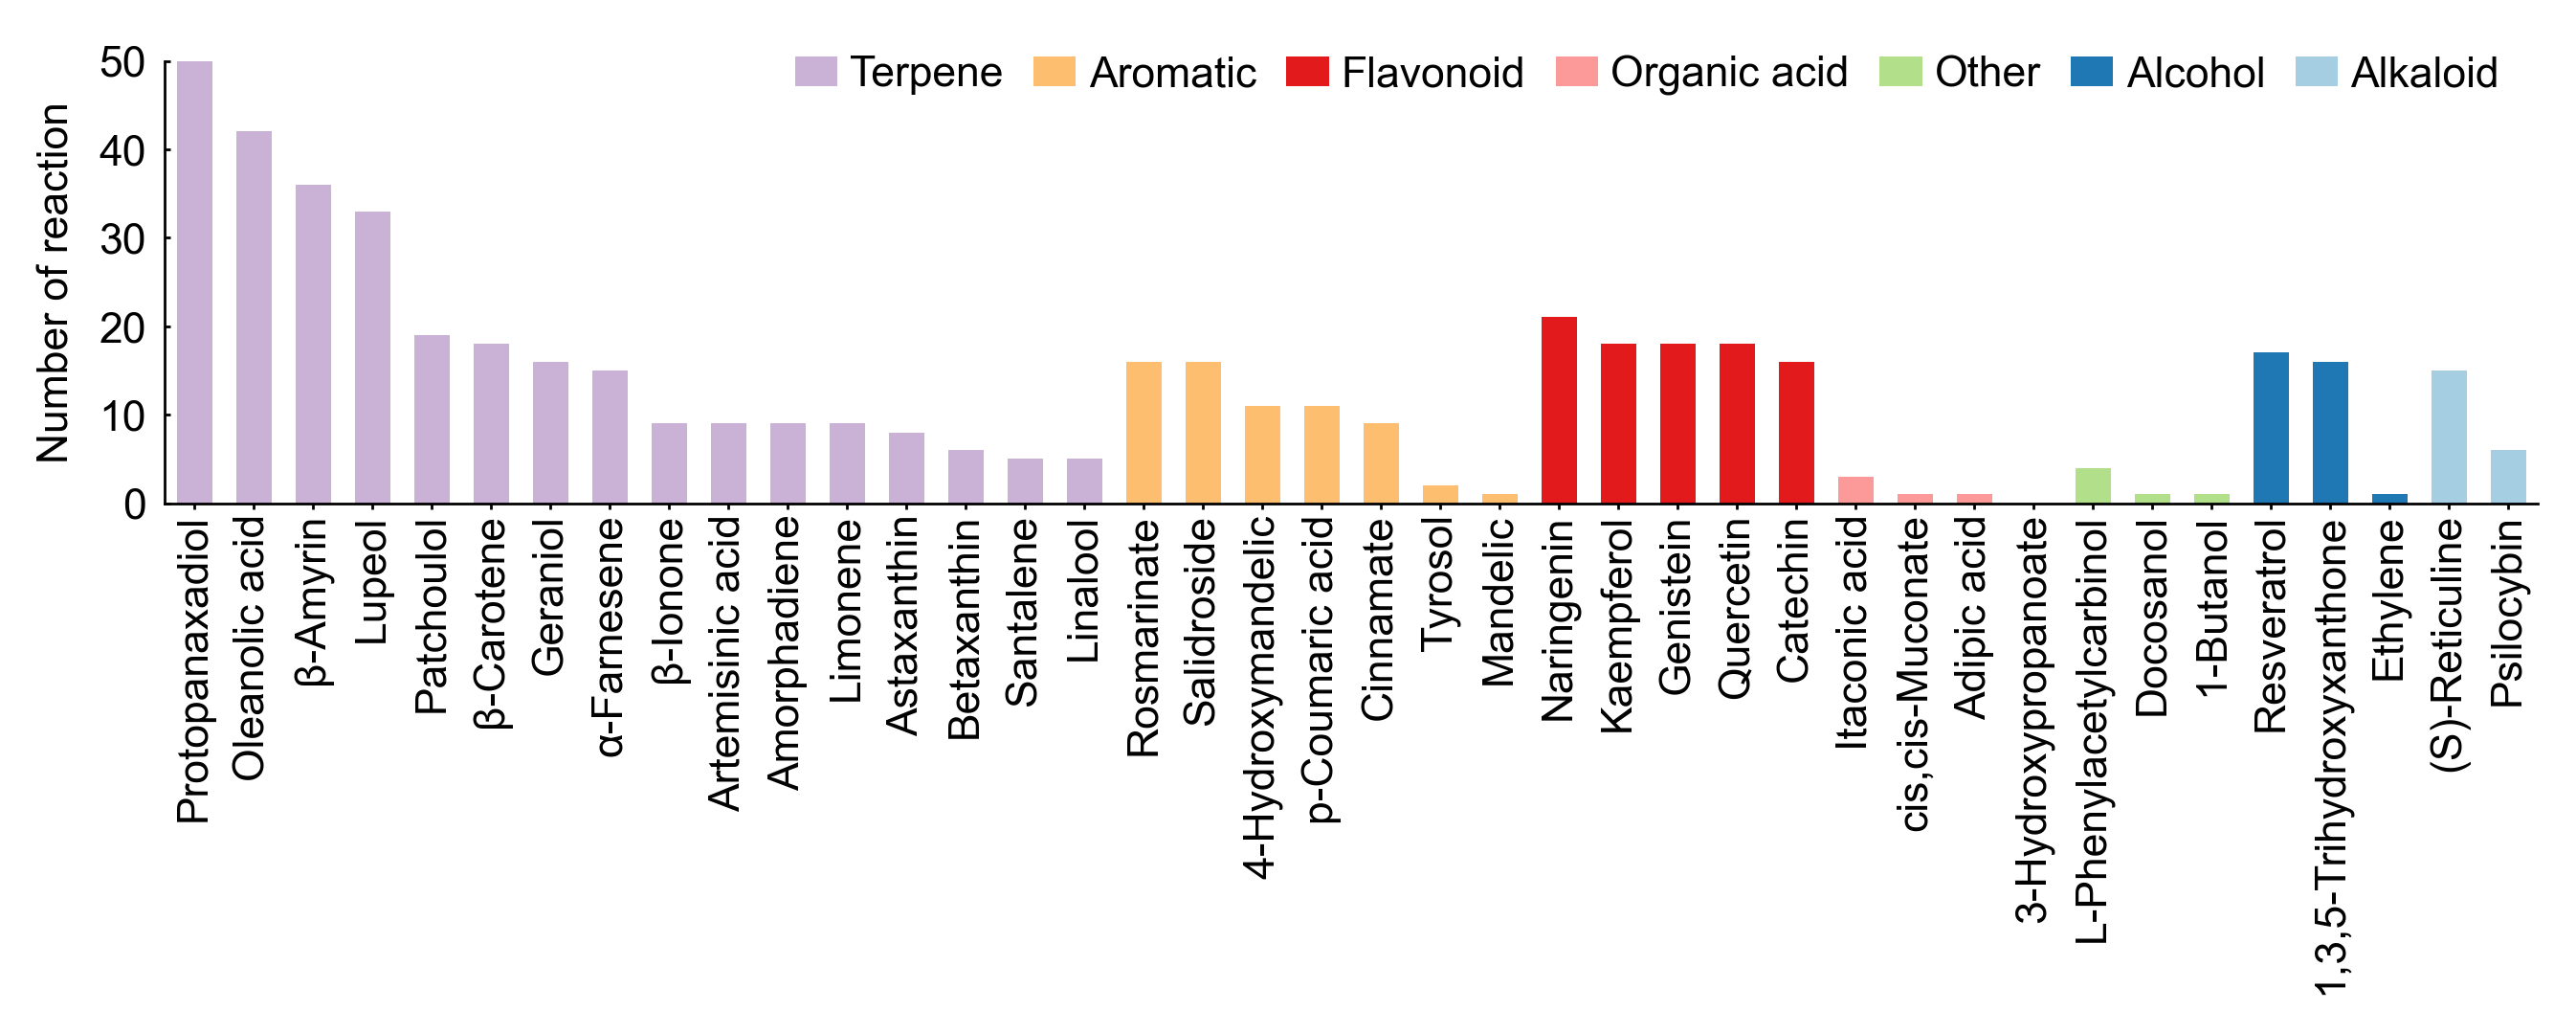

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Setting General Parameters
plt.figure(figsize=(8, 1.5), dpi=400)
plt.rcParams.update({'font.size': 8})
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42

# Setting Axis Styles
plt.gca().spines['top'].set_linewidth(0)
plt.gca().spines['bottom'].set_linewidth(0.5)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['right'].set_linewidth(0)

# Plot vertical bar charts
bar_width = 0.6
index = np.arange(len(target_100met_df['Name']))
plt.bar(index[0:16], target_100met_df['byproduct_num'][0:16], width=bar_width, label='Terpene', color='#cab2d6')
plt.bar(index[16:23], target_100met_df['byproduct_num'][16:23], width=bar_width, label='Aromatic', color='#fdbf6f')
plt.bar(index[23:28], target_100met_df['byproduct_num'][23:28], width=bar_width, label='Flavonoid', color='#e31a1c')
plt.bar(index[28:32], target_100met_df['byproduct_num'][28:32], width=bar_width, label='Organic acid', color='#fb9a99')
plt.bar(index[32:35], target_100met_df['byproduct_num'][32:35], width=bar_width, label='Other', color='#b2df8a')
plt.bar(index[35:38], target_100met_df['byproduct_num'][35:38], width=bar_width, label='Alcohol', color='#1f78b4')
plt.bar(index[38:40], target_100met_df['byproduct_num'][38:40], width=bar_width, label='Alkaloid', color='#a6cee3')

# Setting Axis Parameters
plt.tick_params(axis='y', direction='in', width=0.5, which='both', length=1)
plt.tick_params(axis='x', direction='out', width=0.5, which='both', length=1, pad=1)
plt.ylim(0, 50)
plt.xlim(-0.5, 39.5)
plt.yticks(np.arange(0, 51, 10), fontsize=8)
plt.xticks(index, target_100met_df['Name'], fontsize=8, rotation=90)
plt.ylabel('Number of reaction', fontsize=8)

# Add legend
plt.legend(frameon=False, fontsize=8, loc='upper right', bbox_to_anchor=(1, 1.1), labelspacing=0.5, handletextpad=0.3, handlelength=1, ncol=7, columnspacing=0.7)

# Display and save the plot
# plt.savefig(yeast8U_heterologous_product_reaction_figure_path, dpi=400, bbox_inches='tight')
plt.show()
